# 官网教程的代码

[地址](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

In [1]:
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

单词到索引、索引到单词的转换

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self,name):
        self.name = name
        # 单词到索引的转换
        self.word2index = {}
        # 单词计数
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # 单词数量统计
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self,word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] + 1    

这些文件都是Unicode格式的，为了简化，我们将Unicode字符转换为ASCII，所有字符都小写，并减少大多数标点符号。

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

为了读取数据文件，我们将把文件分成行，然后把行分成对。这些文件都是英语其他语言的，所以如果我们想从其他语言翻译英语，我添加了反向标志来反向对。

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

先快速训练，所以我们将把数据集缩减到相对简短的句子。在这里，最大长度是10个单词(包括结束标点)，我们重新过滤句子，将其翻译成I am或He is等形式(包括前面替换的撇号)

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# 过滤长度为10
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 167130 sentence pairs
Trimmed to 12441 sentence pairs
Counting words...
Counted words:
fra 4706
eng 3030
['je suis vraiment contente .', 'i m really happy .']


### 编码器

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 解码器

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size=hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden_):
        output = self.embedding(input_).view(1,1,-1)
        output = F.relue(output)
        output,hidden = self.gru(output_,hidden_)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1,max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input_, hidden_, encoder_outputs):
        embedded = self.embedding(input_).view(1,1,-1)
        embedded = self.dropout(embedded)
        
        # 计算encoder信息的softmax权重
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden_[0]), 1)), dim=1)
        # 通过权重，计算encoder在这一轮的信息
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        # 合并input和encoder的信息
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # 通过线性网络整理形状
        output = self.attn_combine(output).unsqueeze(0)
        # 送入网络
        output = F.relu(output)
        output, hidden = self.gru(output, hidden_)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# 训练

### 准备数据

In [10]:
# 从句子返回索引list
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

# 对句子加上EOS结束符号，
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# 返回一对句子
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 模型
对Encoder，跟踪每一个步骤的输出，以及最后一个隐藏状态；对Decoder，以sos作为其第一个输入，且Encoder的最后一个隐藏状态作为第一个隐藏状态

'teacher forcing' 是一个概念：使用目标输出作为下一个输入，而不是让解码器去猜测；这种方式会收敛很快，但是在应用的时候会不稳定

这里随机选择是否使用'teacher forcing'方法

In [11]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0) # shape:seq_len,batch_size, embedding_size
    target_length = target_tensor.size(0)
    
    # 编码器输出矩阵
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    #解码器第一个输入是开始标志符号
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    # 解码器隐藏状态使用编码器最后的隐藏状态
    decoder_hidden = encoder_hidden
    
    # 是否使用 teacher forcing 技术
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
            
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            
            # 截断反向传播梯度流作为输入
            # 因为输入本身就是一个数字，所以可以直接输入最大值索引
            decoder_input = topi.squeeze().detach() 
            
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
                
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/target_length

帮助函数

In [12]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [14]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [15]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [16]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

8m 25s (- 118m 1s) (5000 6%) 2.8666
16m 39s (- 108m 17s) (10000 13%) 2.2985
23m 54s (- 95m 37s) (15000 20%) 2.0124
30m 53s (- 84m 57s) (20000 26%) 1.7624
38m 56s (- 77m 52s) (25000 33%) 1.6046
47m 7s (- 70m 41s) (30000 40%) 1.3846
54m 55s (- 62m 46s) (35000 46%) 1.2688
62m 42s (- 54m 52s) (40000 53%) 1.1763
70m 17s (- 46m 51s) (45000 60%) 1.0550
78m 14s (- 39m 7s) (50000 66%) 0.9595
85m 46s (- 31m 11s) (55000 73%) 0.8938
94m 44s (- 23m 41s) (60000 80%) 0.8256
104m 7s (- 16m 1s) (65000 86%) 0.7670
113m 23s (- 8m 5s) (70000 93%) 0.7043
122m 33s (- 0m 0s) (75000 100%) 0.6480


<Figure size 432x288 with 0 Axes>

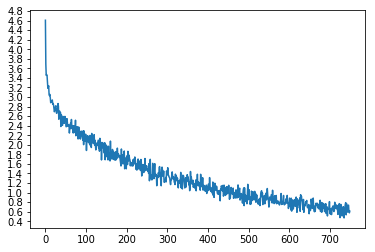

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [18]:
evaluateRandomly(encoder1, attn_decoder1)

> tu es responsable de ce resultat .
= you are responsible for the result .
< you are responsible for what tom . <EOS>

> il est parti au maquis .
= he s gone into hiding .
< he is used to the hard . <EOS>

> c est un adversaire redoutable .
= he is a formidable opponent .
< he is a a friend . <EOS>

> je le fais moi meme .
= i m doing it myself .
< i m doing it right . <EOS>

> c est une gentille personne .
= he is a nice person .
< she is a beauty person . <EOS>

> c est un bon nageur .
= he is a good swimmer .
< he is a good swimmer . <EOS>

> ils sont mignons .
= they re cute .
< they re cute . <EOS>

> tu es fort raffine .
= you re very sophisticated .
< you re very sophisticated . <EOS>

> vous avez probablement raison .
= you re probably right .
< you re right right . <EOS>

> j etudie le genie electrique .
= i m studying electrical engineering .
< i m studying in french . <EOS>



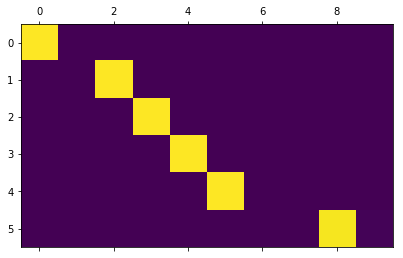

In [19]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


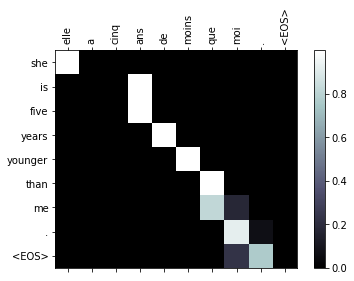

input = elle est trop petit .
output = she is too poor . <EOS>


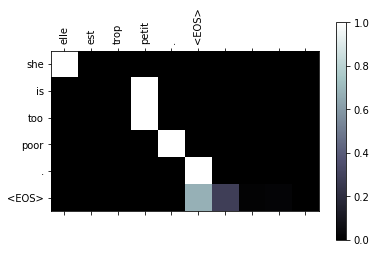

input = je ne crains pas de mourir .
output = i m not afraid . <EOS>


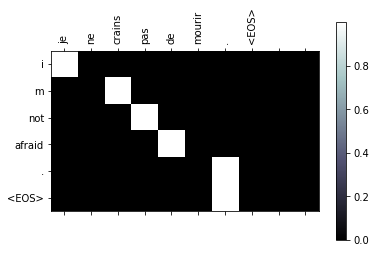

input = c est un jeune directeur plein de talent .
output = he s a born young . <EOS>


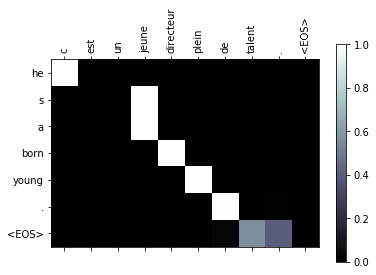

In [20]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")